'''
Embeddings are clusters of vectors in multi-dimensional space, where each vector represents a given word in those 
dimensions. TensorFlow Projector makes it fairly easy for us to view these clusters in a 3D.

This can be very useful for sentiment analysis models, where you’d expect to see clusters around either more 
positive or more negative sentiment associated with each word.
An example embedding projection, post-training. Negative sentiment words are separated quite distinctly 
from positive sentiment words, such as “incredible”.
'''

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Flatten
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [4]:
#!wget --no-check-certificate \
#    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

# https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set

In [5]:
path = tf.keras.utils.get_file('sentiment.csv', 
                               'https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P')
print (path)

C:\Users\Amir\.keras\datasets\sentiment.csv


In [6]:
df = pd.read_csv(path)

In [7]:
df.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


In [8]:
df = df.drop(["Unnamed: 0"], axis=1)

In [9]:
df.head()

,text,sentiment
0,So there is no way for me to plug it in here i...,0
1,Good case Excellent value.,1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [10]:
X = df['text']
y = df['sentiment']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [12]:
X_train_original = X_train
X_test_original  = X_test

In [13]:
MAX_VOCAB_SIZE = 20000

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)

In [14]:
tokenizer.fit_on_texts(X_train)  # Convert sentences to number sequences

In [15]:
X_train = tokenizer.texts_to_sequences(X_train)

In [16]:
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
word_index = tokenizer.word_index

In [18]:
len(word_index)

2847

In [19]:
# pad sequences so that we get a N x T matrix

X_train = pad_sequences(X_train)
print('Shape of train tensor:', X_train.shape)

# get sequence length
T = X_train.shape[1]

Shape of train tensor: (1593, 139)


In [20]:
X_test = pad_sequences(X_test, maxlen=T)
print('Shape of test tensor:', X_test.shape)

Shape of test tensor: (399, 139)


In [21]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(X_train[1]))
print(X_train_original[1])

? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? level 5 spicy was perfect where spice didn't over whelm the soup
Good case Excellent value.


In [22]:
# We get to choose embedding dimensionality
D = 16 # 20
V = len(word_index)

i = Input(shape=(T,))                        # T = 121
x = Embedding(V + 1, D)(i)                   # V = 7246   D = 20
x = Flatten()(x)
x = Dense(6, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 139)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 139, 16)           45568     
_________________________________________________________________
flatten (Flatten)            (None, 2224)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 13350     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 58,925
Trainable params: 58,925
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [24]:
epochs = 10

history = model.fit(
  X_train,
  y_train,
  epochs=epochs,
  validation_data=(X_test, y_test)
)

Epoch 1/10
50/50 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6930 - val_accuracy: 0.5414
Epoch 2/10
50/50 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5342 - val_loss: 0.6906 - val_accuracy: 0.5038
Epoch 3/10
50/50 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.5895 - val_loss: 0.6805 - val_accuracy: 0.5338
Epoch 4/10
50/50 [==============================] - 0s 4ms/step - loss: 0.6484 - accuracy: 0.6460 - val_loss: 0.6560 - val_accuracy: 0.5439
Epoch 5/10
50/50 [==============================] - 0s 4ms/step - loss: 0.5330 - accuracy: 0.8927 - val_loss: 0.5498 - val_accuracy: 0.7920
Epoch 6/10
50/50 [==============================] - 0s 4ms/step - loss: 0.3571 - accuracy: 0.9422 - val_loss: 0.4841 - val_accuracy: 0.7970
Epoch 7/10
50/50 [==============================] - 0s 4ms/step - loss: 0.2353 - accuracy: 0.9623 - val_loss: 0.4495 - val_accuracy: 0.7945
Epoch 8/10
50/50 [==

In [25]:
model.history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

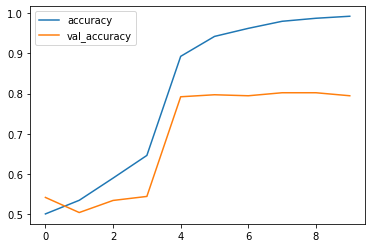

In [27]:
losses[['accuracy','val_accuracy']].plot()

<AxesSubplot:>

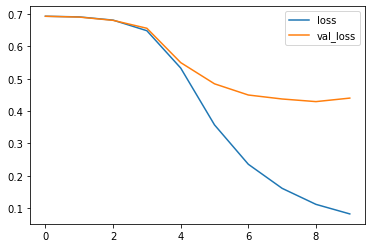

In [28]:
losses[['loss','val_loss']].plot()

In [29]:
# Head to http://projector.tensorflow.org/ and load these files, then click the "Sphereize" checkbox.
#  
# First get the weights of the embedding layer
e = model.layers[1]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(2848, 16)


In [30]:
'''
import io

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, MAX_VOCAB_SIZE):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()
'''

'\nimport io\n\n# Write out the embedding vectors and metadata\nout_v = io.open(\'vecs.tsv\', \'w\', encoding=\'utf-8\')\nout_m = io.open(\'meta.tsv\', \'w\', encoding=\'utf-8\')\nfor word_num in range(1, MAX_VOCAB_SIZE):\n  word = reverse_word_index[word_num]\n  embeddings = weights[word_num]\n  out_m.write(word + "\n")\n  out_v.write(\'\t\'.join([str(x) for x in embeddings]) + "\n")\nout_v.close()\nout_m.close()\n'

In [31]:
'''
# Download the files
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')
'''

"\n# Download the files\ntry:\n  from google.colab import files\nexcept ImportError:\n  pass\nelse:\n  files.download('vecs.tsv')\n  files.download('meta.tsv')\n"

In [33]:
# Predicting Sentiment in New Reviews Use the model to predict a review   
fake_reviews = ['I love this phone', 'I hate spaghetti', 
                'Everything was cold',
                'Everything was hot exactly as I wanted', 
                'Everything was green', 
                'the host seated us immediately',
                'they gave us free chocolate cake', 
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes',
                'bats are all wearing underwears with tie',
                'bat was runnig the show',
                'does not work when I stand on my head']

print(fake_reviews) 

# Create the sequences - Numerize the text

sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, maxlen=T)  

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')              

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
  print(fake_reviews[x])
  print(classes[x])
  print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'bats are all wearing underwears with tie', 'bat was runnig the show', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

I love this phone
[0.9764925]


I hate spaghetti
[0.10881436]


Everything was cold
[0.14792123]


Everything was hot exactly as I wanted
[0.78971887]


Everything was green
[0.42731863]


the host seated us immediately
[0.84841144]


they gave us free chocolate cake
[0.6431345]


not sure about the wilted flowers on the table
[0.03724581]


only works when I stand on tippy toes
[0.48206332]


bats are all wearing underwears with tie
[0.36780372]


bat was runnig the show
[0.5051883]


does not work when I stand o